# Phase Transitions: States of Dead Token Matter

Classify dead tokens into phases based on their lattice displacement magnitude |ΔW′|.

**Phases:**
- **Fimbulwinter:** |ΔW′| < 0.1 ULP — frozen, no observable motion
- **Stumbling:** 0.1–1 ULP — single-cell hops, last gasp before freeze
- **Thermal:** 1–10 ULP — slow drift, few-cell hops
- **Quantum Regime:** 10–100 ULP — significant hopping
- **Classical Gas:** > 100 ULP — free flight, supernova territory

**Input:** Crucible 1 trajectory data

## Parameters

In [13]:
# Paths
INPUT_PATH = '../../tensors/Crucible-1/crucible_1_trajectory.safetensors'

# Phase thresholds (in ULP / lattice cells)
THRESH_FIMBULWINTER = 0.1   # Below this: frozen
THRESH_STUMBLING = 1.0      # Below this: stumbling (single-cell hops)
THRESH_THERMAL = 10.0       # Below this: thermal
THRESH_QUANTUM = 100.0      # Below this: quantum regime; above: classical gas

# Plotting
DPI = 250
FIGSIZE = (14, 6)

## Imports

In [14]:
import torch
from safetensors.torch import load_file
import matplotlib.pyplot as plt
import numpy as np

## Load Data

In [15]:
data = load_file(INPUT_PATH)
delta_W_prime = data['delta_W_prime']  # (4000, 3699, 64) float32

n_steps, n_tokens, n_dims = delta_W_prime.shape
print(f"Shape: {delta_W_prime.shape}")
print(f"Steps: {n_steps}, Dead tokens: {n_tokens}, Dims: {n_dims}")

Shape: torch.Size([5000, 3699, 64])
Steps: 5000, Dead tokens: 3699, Dims: 64


## Compute Per-Token Displacement Magnitude

For each token at each timestep, compute the L2 norm of ΔW′ across dimensions.
This gives a single scalar "how far did this token move" per token per step.

In [16]:
# |ΔW′|₂ for each token at each step
# Shape: (4000, 3699)
displacement_magnitude = torch.norm(delta_W_prime, dim=2)

print(f"Displacement magnitude shape: {displacement_magnitude.shape}")
print(f"Range: [{displacement_magnitude.min():.4f}, {displacement_magnitude.max():.4f}]")

Displacement magnitude shape: torch.Size([5000, 3699])
Range: [0.0000, inf]


## Classify Into Phases

In [17]:
# Classify each token at each timestep into five phases
is_fimbulwinter = displacement_magnitude < THRESH_FIMBULWINTER
is_stumbling = (displacement_magnitude >= THRESH_FIMBULWINTER) & (displacement_magnitude < THRESH_STUMBLING)
is_thermal = (displacement_magnitude >= THRESH_STUMBLING) & (displacement_magnitude < THRESH_THERMAL)
is_quantum = (displacement_magnitude >= THRESH_THERMAL) & (displacement_magnitude < THRESH_QUANTUM)
is_classical = displacement_magnitude >= THRESH_QUANTUM

# Compute fractions at each timestep
frac_fimbulwinter = is_fimbulwinter.float().mean(dim=1).numpy()
frac_stumbling = is_stumbling.float().mean(dim=1).numpy()
frac_thermal = is_thermal.float().mean(dim=1).numpy()
frac_quantum = is_quantum.float().mean(dim=1).numpy()
frac_classical = is_classical.float().mean(dim=1).numpy()

# Sanity check: fractions should sum to 1
total = frac_fimbulwinter + frac_stumbling + frac_thermal + frac_quantum + frac_classical
print(f"Fraction sum range: [{total.min():.6f}, {total.max():.6f}] (should be 1.0)")

Fraction sum range: [1.000000, 1.000000] (should be 1.0)


## Stacked Area Plot

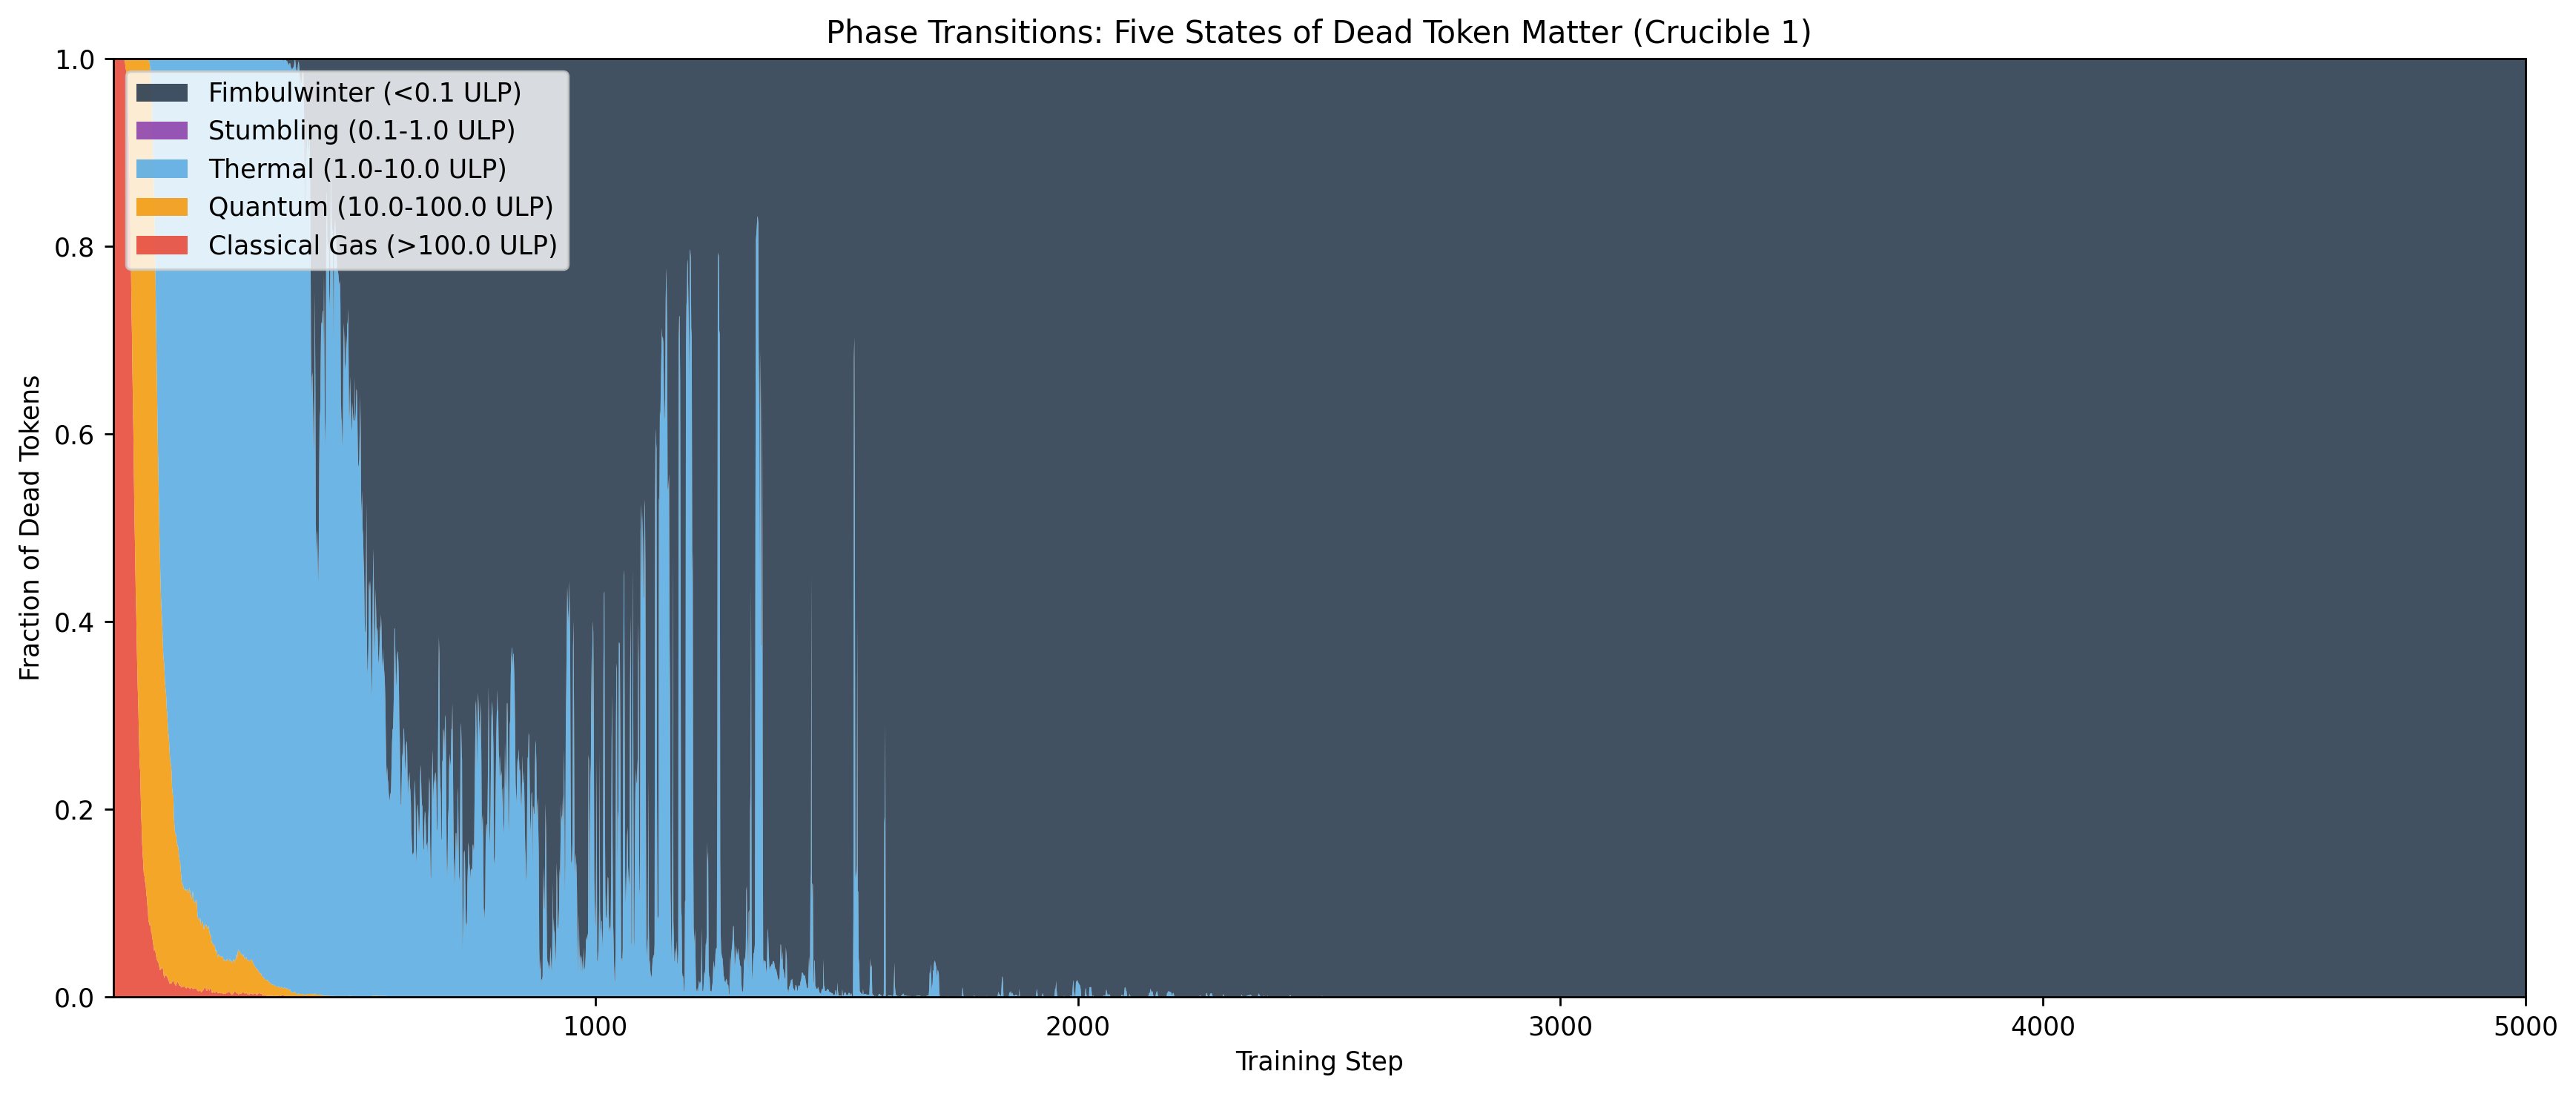

In [18]:
steps = np.arange(1, n_steps + 1)

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Stack from bottom to top: Classical, Quantum, Thermal, Stumbling, Fimbulwinter
ax.stackplot(
    steps,
    frac_classical,
    frac_quantum,
    frac_thermal,
    frac_stumbling,
    frac_fimbulwinter,
    labels=[
        f'Classical Gas (>{THRESH_QUANTUM} ULP)',
        f'Quantum ({THRESH_THERMAL}-{THRESH_QUANTUM} ULP)',
        f'Thermal ({THRESH_STUMBLING}-{THRESH_THERMAL} ULP)',
        f'Stumbling ({THRESH_FIMBULWINTER}-{THRESH_STUMBLING} ULP)',
        f'Fimbulwinter (<{THRESH_FIMBULWINTER} ULP)',
    ],
    colors=['#e74c3c', '#f39c12', '#5dade2', '#8e44ad', '#2c3e50'],
    alpha=0.9
)

ax.set_xlabel('Training Step')
ax.set_ylabel('Fraction of Dead Tokens')
ax.set_title('Phase Transitions: Five States of Dead Token Matter (Crucible 1)')
ax.set_xlim(1, n_steps)
ax.set_ylim(0, 1)

# Legend in reverse order to match visual stacking
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left')

plt.tight_layout()
plt.show()

## Key Statistics

In [19]:
print("=" * 60)
print("PHASE TRANSITION STATISTICS")
print("=" * 60)

# When does Fimbulwinter first reach 50%? 90%? 99%?
for threshold in [0.5, 0.9, 0.99]:
    idx = np.where(frac_fimbulwinter >= threshold)[0]
    if len(idx) > 0:
        step = idx[0] + 1  # +1 because steps are 1-indexed
        print(f"Fimbulwinter reaches {threshold:.0%} at step {step}")
    else:
        print(f"Fimbulwinter never reaches {threshold:.0%}")

print()

# When does Classical Gas drop below 1%? 0.1%? 0%?
for threshold in [0.01, 0.001, 0.0]:
    idx = np.where(frac_classical <= threshold)[0]
    if len(idx) > 0:
        step = idx[0] + 1
        print(f"Classical Gas drops below {threshold:.1%} at step {step}")
    else:
        print(f"Classical Gas never drops below {threshold:.1%}")

print()

# When does Stumbling peak?
stumble_peak_step = np.argmax(frac_stumbling) + 1
stumble_peak_frac = frac_stumbling.max()
print(f"Stumbling phase peaks at step {stumble_peak_step} ({stumble_peak_frac:.1%} of tokens)")

print()

# Final state
print(f"Final state (step {n_steps}):")
print(f"  Fimbulwinter: {frac_fimbulwinter[-1]:.1%}")
print(f"  Stumbling: {frac_stumbling[-1]:.1%}")
print(f"  Thermal: {frac_thermal[-1]:.1%}")
print(f"  Quantum: {frac_quantum[-1]:.1%}")
print(f"  Classical: {frac_classical[-1]:.1%}")

PHASE TRANSITION STATISTICS
Fimbulwinter reaches 50% at step 422
Fimbulwinter reaches 90% at step 725
Fimbulwinter reaches 99% at step 1184

Classical Gas drops below 1.0% at step 142
Classical Gas drops below 0.1% at step 312
Classical Gas drops below 0.0% at step 363

Stumbling phase peaks at step 1 (0.0% of tokens)

Final state (step 5000):
  Fimbulwinter: 100.0%
  Stumbling: 0.0%
  Thermal: 0.0%
  Quantum: 0.0%
  Classical: 0.0%


## Mean Displacement Over Time

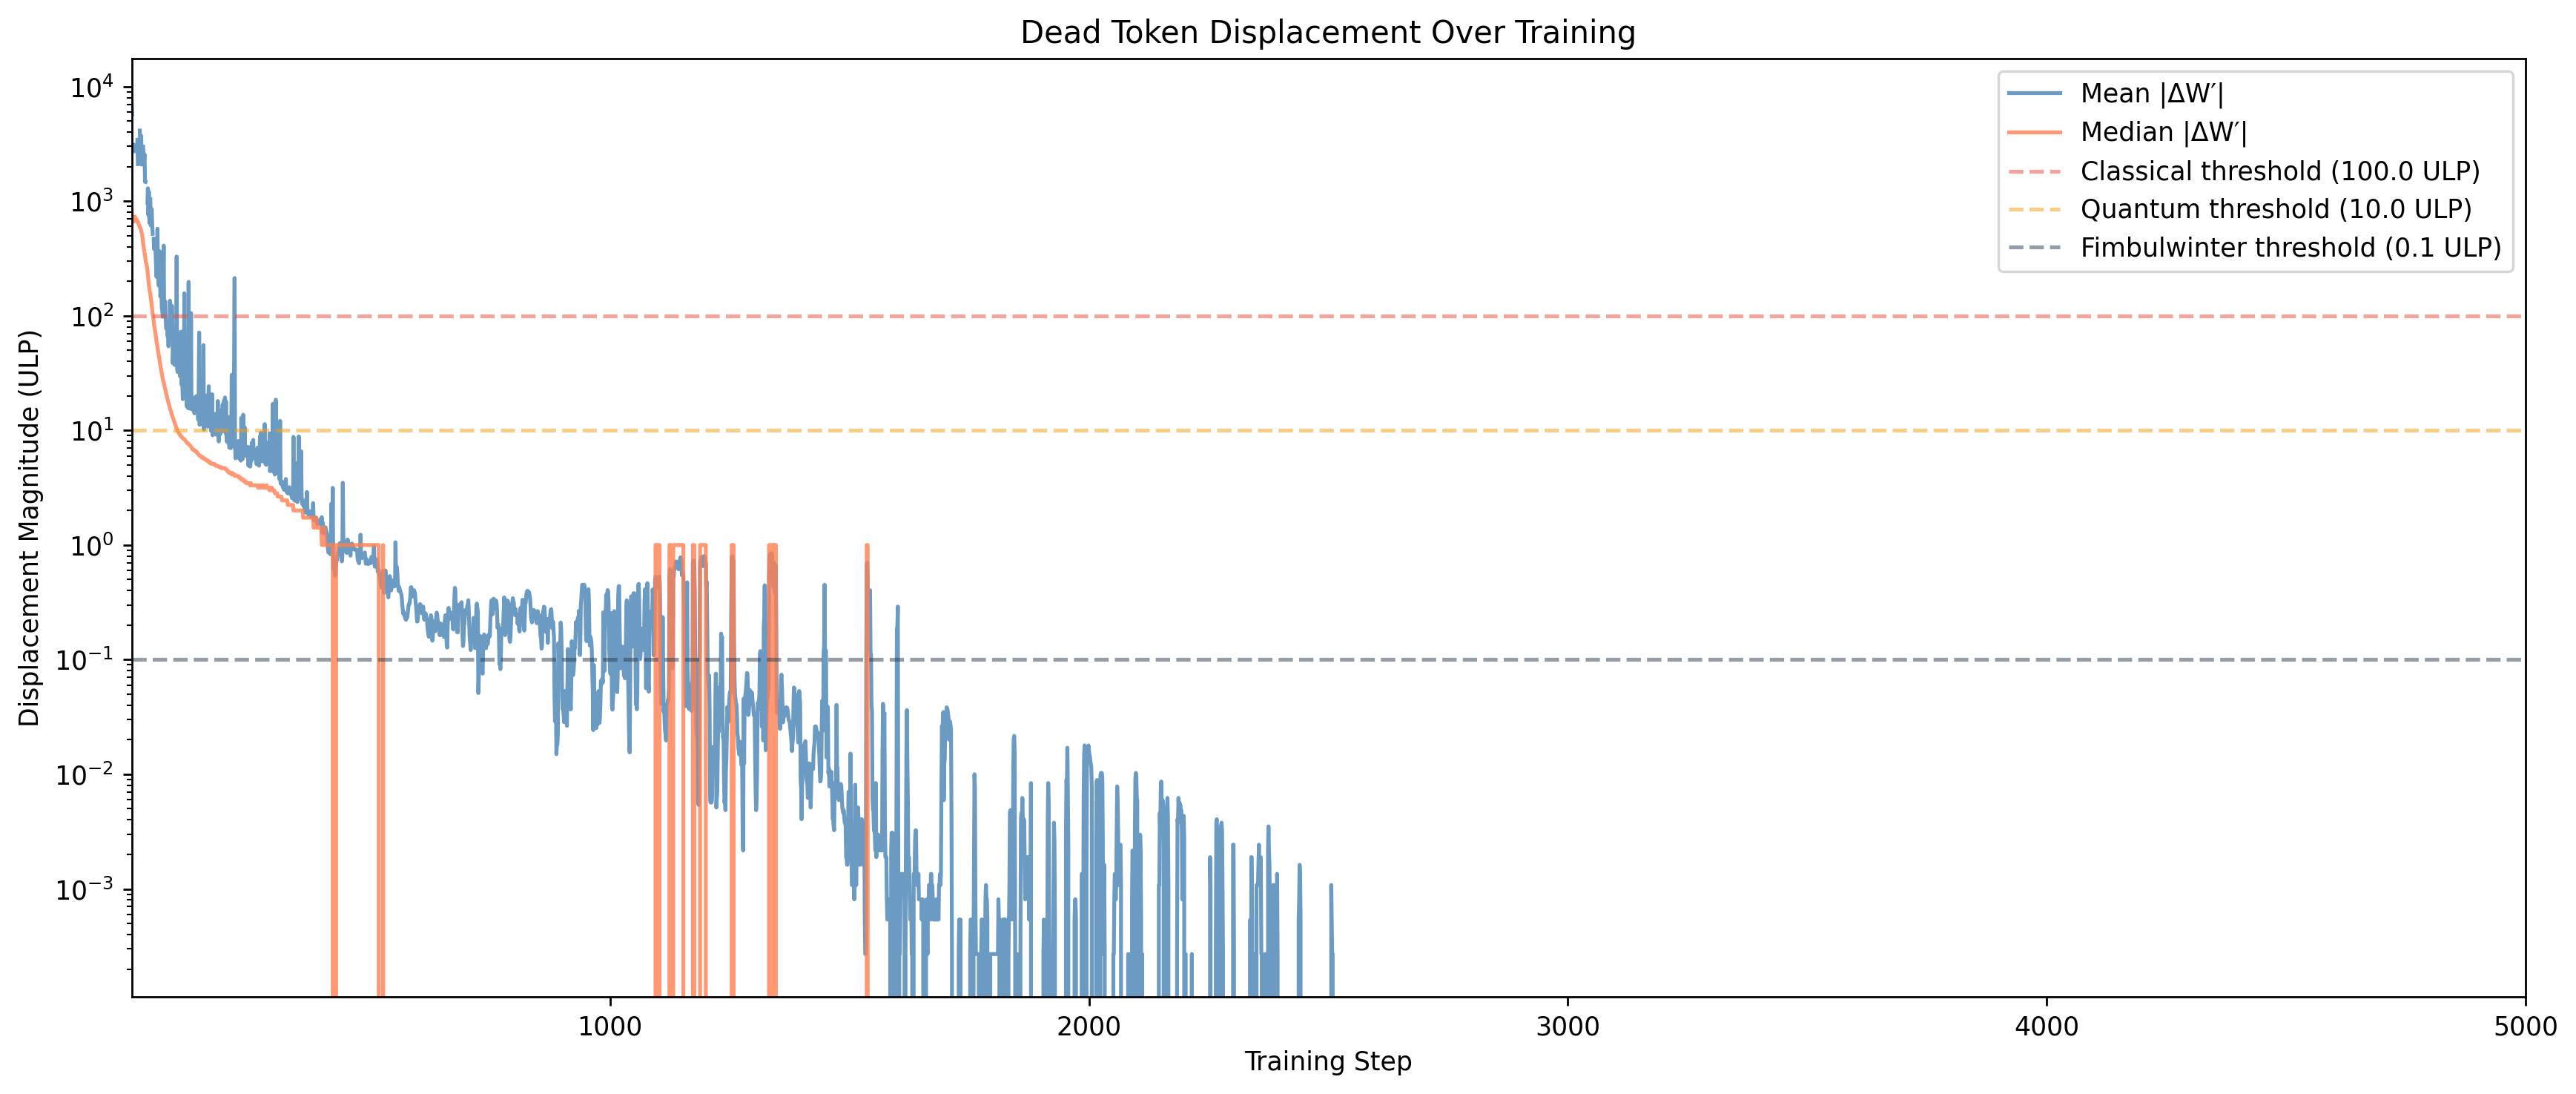

In [20]:
# Mean and median displacement across all dead tokens at each step
mean_displacement = displacement_magnitude.mean(dim=1).numpy()
median_displacement = displacement_magnitude.median(dim=1).values.numpy()

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.semilogy(steps, mean_displacement, label='Mean |ΔW′|', color='steelblue', alpha=0.8)
ax.semilogy(steps, median_displacement, label='Median |ΔW′|', color='coral', alpha=0.8)

# Add threshold lines
ax.axhline(THRESH_QUANTUM, color='#e74c3c', linestyle='--', alpha=0.5, label=f'Classical threshold ({THRESH_QUANTUM} ULP)')
ax.axhline(THRESH_THERMAL, color='#f39c12', linestyle='--', alpha=0.5, label=f'Quantum threshold ({THRESH_THERMAL} ULP)')
ax.axhline(THRESH_FIMBULWINTER, color='#2c3e50', linestyle='--', alpha=0.5, label=f'Fimbulwinter threshold ({THRESH_FIMBULWINTER} ULP)')

ax.set_xlabel('Training Step')
ax.set_ylabel('Displacement Magnitude (ULP)')
ax.set_title('Dead Token Displacement Over Training')
ax.set_xlim(1, n_steps)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Stumbling Phase Analysis

For each token, identify:
- **t_last_big**: Last step with |ΔW′| > 1 (multi-cell hop)
- **t_last_any**: Last step with any motion (|ΔW′| > threshold)
- **Stumbling duration**: The interval between them—single-quantum hops only

This captures the approach to freezing: tokens stop making big jumps, then stumble along one lattice cell at a time, then freeze completely.

In [21]:
def last_step_above_threshold(displacement, threshold):
    """
    For each token, find the last timestep where displacement exceeded threshold.
    
    Args:
        displacement: (n_steps, n_tokens) tensor
        threshold: scalar threshold
    
    Returns:
        (n_tokens,) tensor of timestep indices, or -1 if never exceeded
    """
    mask = displacement > threshold  # (n_steps, n_tokens)
    
    # Flip time axis, find first True (which is last True in original)
    flipped = mask.flip(0)
    
    # argmax returns index of first True; if no True, returns 0
    first_in_flipped = flipped.int().argmax(dim=0)
    
    # Convert back to original time indexing
    n_steps = displacement.shape[0]
    last_step = (n_steps - 1) - first_in_flipped
    
    # Handle tokens that never exceeded threshold
    ever_exceeded = mask.any(dim=0)
    last_step[~ever_exceeded] = -1
    
    return last_step


# Threshold for "any motion" — using 0.1 to match Fimbulwinter boundary
MOTION_THRESHOLD = 0.1

t_last_big = last_step_above_threshold(displacement_magnitude, threshold=1.0)
t_last_any = last_step_above_threshold(displacement_magnitude, threshold=MOTION_THRESHOLD)

print(f"t_last_big range: [{t_last_big.min().item()}, {t_last_big.max().item()}]")
print(f"t_last_any range: [{t_last_any.min().item()}, {t_last_any.max().item()}]")

t_last_big range: [356, 1619]
t_last_any range: [559, 2508]


In [22]:
# Compute stumbling duration for each token
# Only meaningful for tokens that had at least one big hop (t_last_big >= 0)

stumble_duration = t_last_any - t_last_big

# Filter to tokens that actually stumbled (had a big hop, then later motion)
valid_stumble = (t_last_big >= 0) & (stumble_duration >= 0)
stumble_durations_valid = stumble_duration[valid_stumble]

print(f"Tokens with valid stumbling phase: {valid_stumble.sum().item()} / {n_tokens}")
print(f"Stumble duration range: [{stumble_durations_valid.min().item()}, {stumble_durations_valid.max().item()}]")
print(f"Mean stumble duration: {stumble_durations_valid.float().mean().item():.1f} steps")
print(f"Median stumble duration: {stumble_durations_valid.float().median().item():.1f} steps")

Tokens with valid stumbling phase: 3699 / 3699
Stumble duration range: [1, 1888]
Mean stumble duration: 782.1 steps
Median stumble duration: 800.0 steps


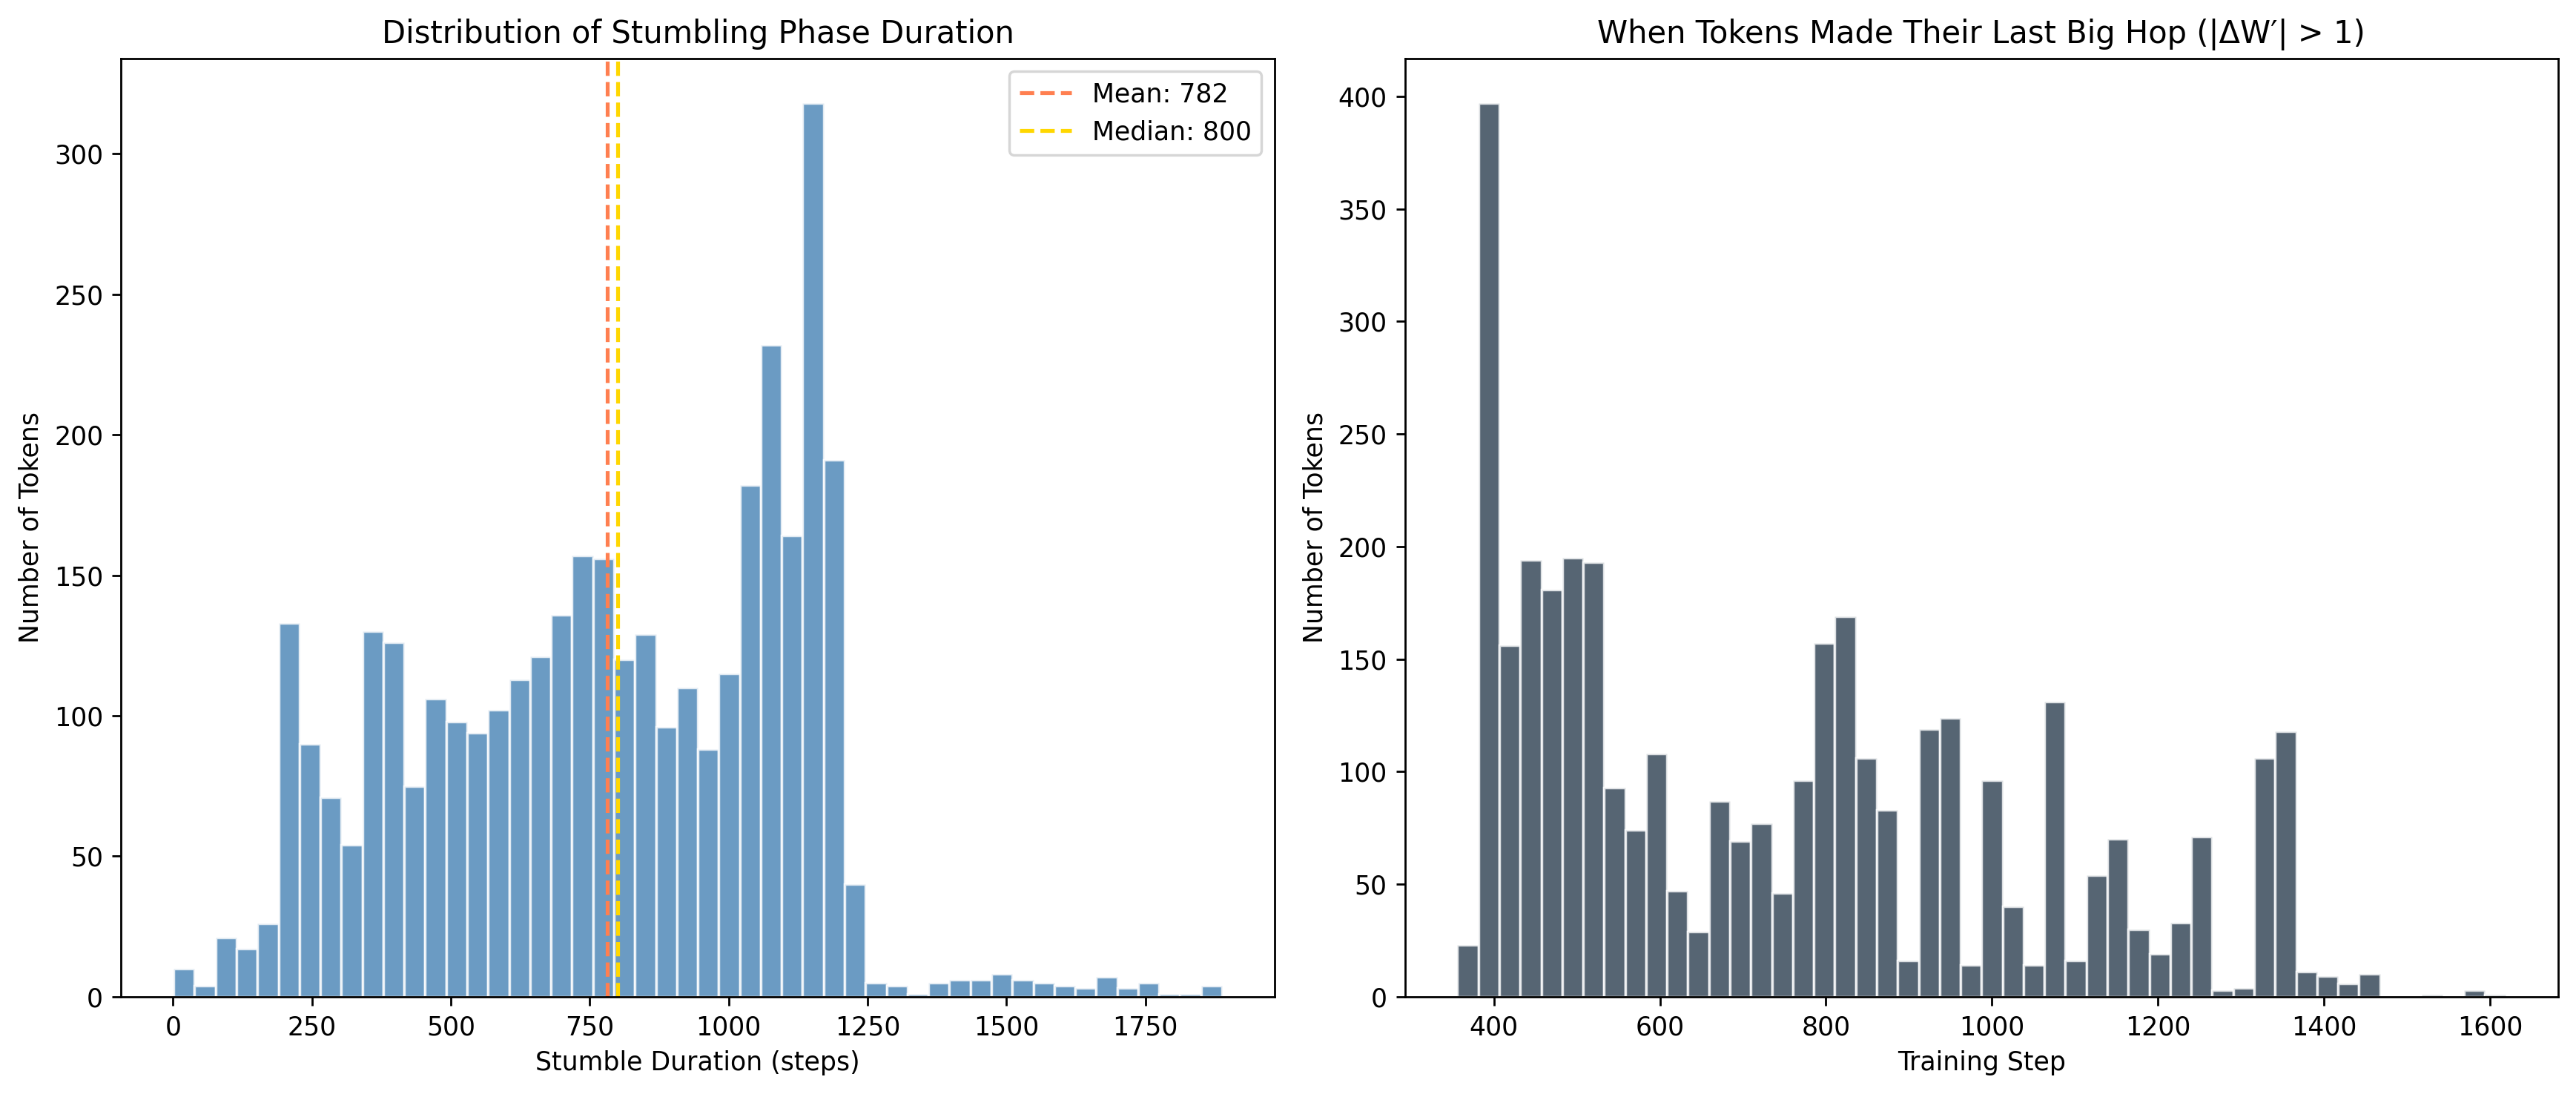

In [23]:
# Histogram of stumble durations
fig, axes = plt.subplots(1, 2, figsize=FIGSIZE, dpi=DPI)

# Left: Full distribution
ax1 = axes[0]
ax1.hist(stumble_durations_valid.numpy(), bins=50, color='steelblue', edgecolor='white', alpha=0.8)
ax1.set_xlabel('Stumble Duration (steps)')
ax1.set_ylabel('Number of Tokens')
ax1.set_title('Distribution of Stumbling Phase Duration')
ax1.axvline(stumble_durations_valid.float().mean().item(), color='coral', linestyle='--', 
            label=f'Mean: {stumble_durations_valid.float().mean().item():.0f}')
ax1.axvline(stumble_durations_valid.float().median().item(), color='gold', linestyle='--',
            label=f'Median: {stumble_durations_valid.float().median().item():.0f}')
ax1.legend()

# Right: When did tokens enter stumbling? (t_last_big distribution)
ax2 = axes[1]
t_last_big_valid = t_last_big[valid_stumble]
ax2.hist(t_last_big_valid.numpy(), bins=50, color='#2c3e50', edgecolor='white', alpha=0.8)
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Number of Tokens')
ax2.set_title('When Tokens Made Their Last Big Hop (|ΔW′| > 1)')

plt.tight_layout()
plt.show()

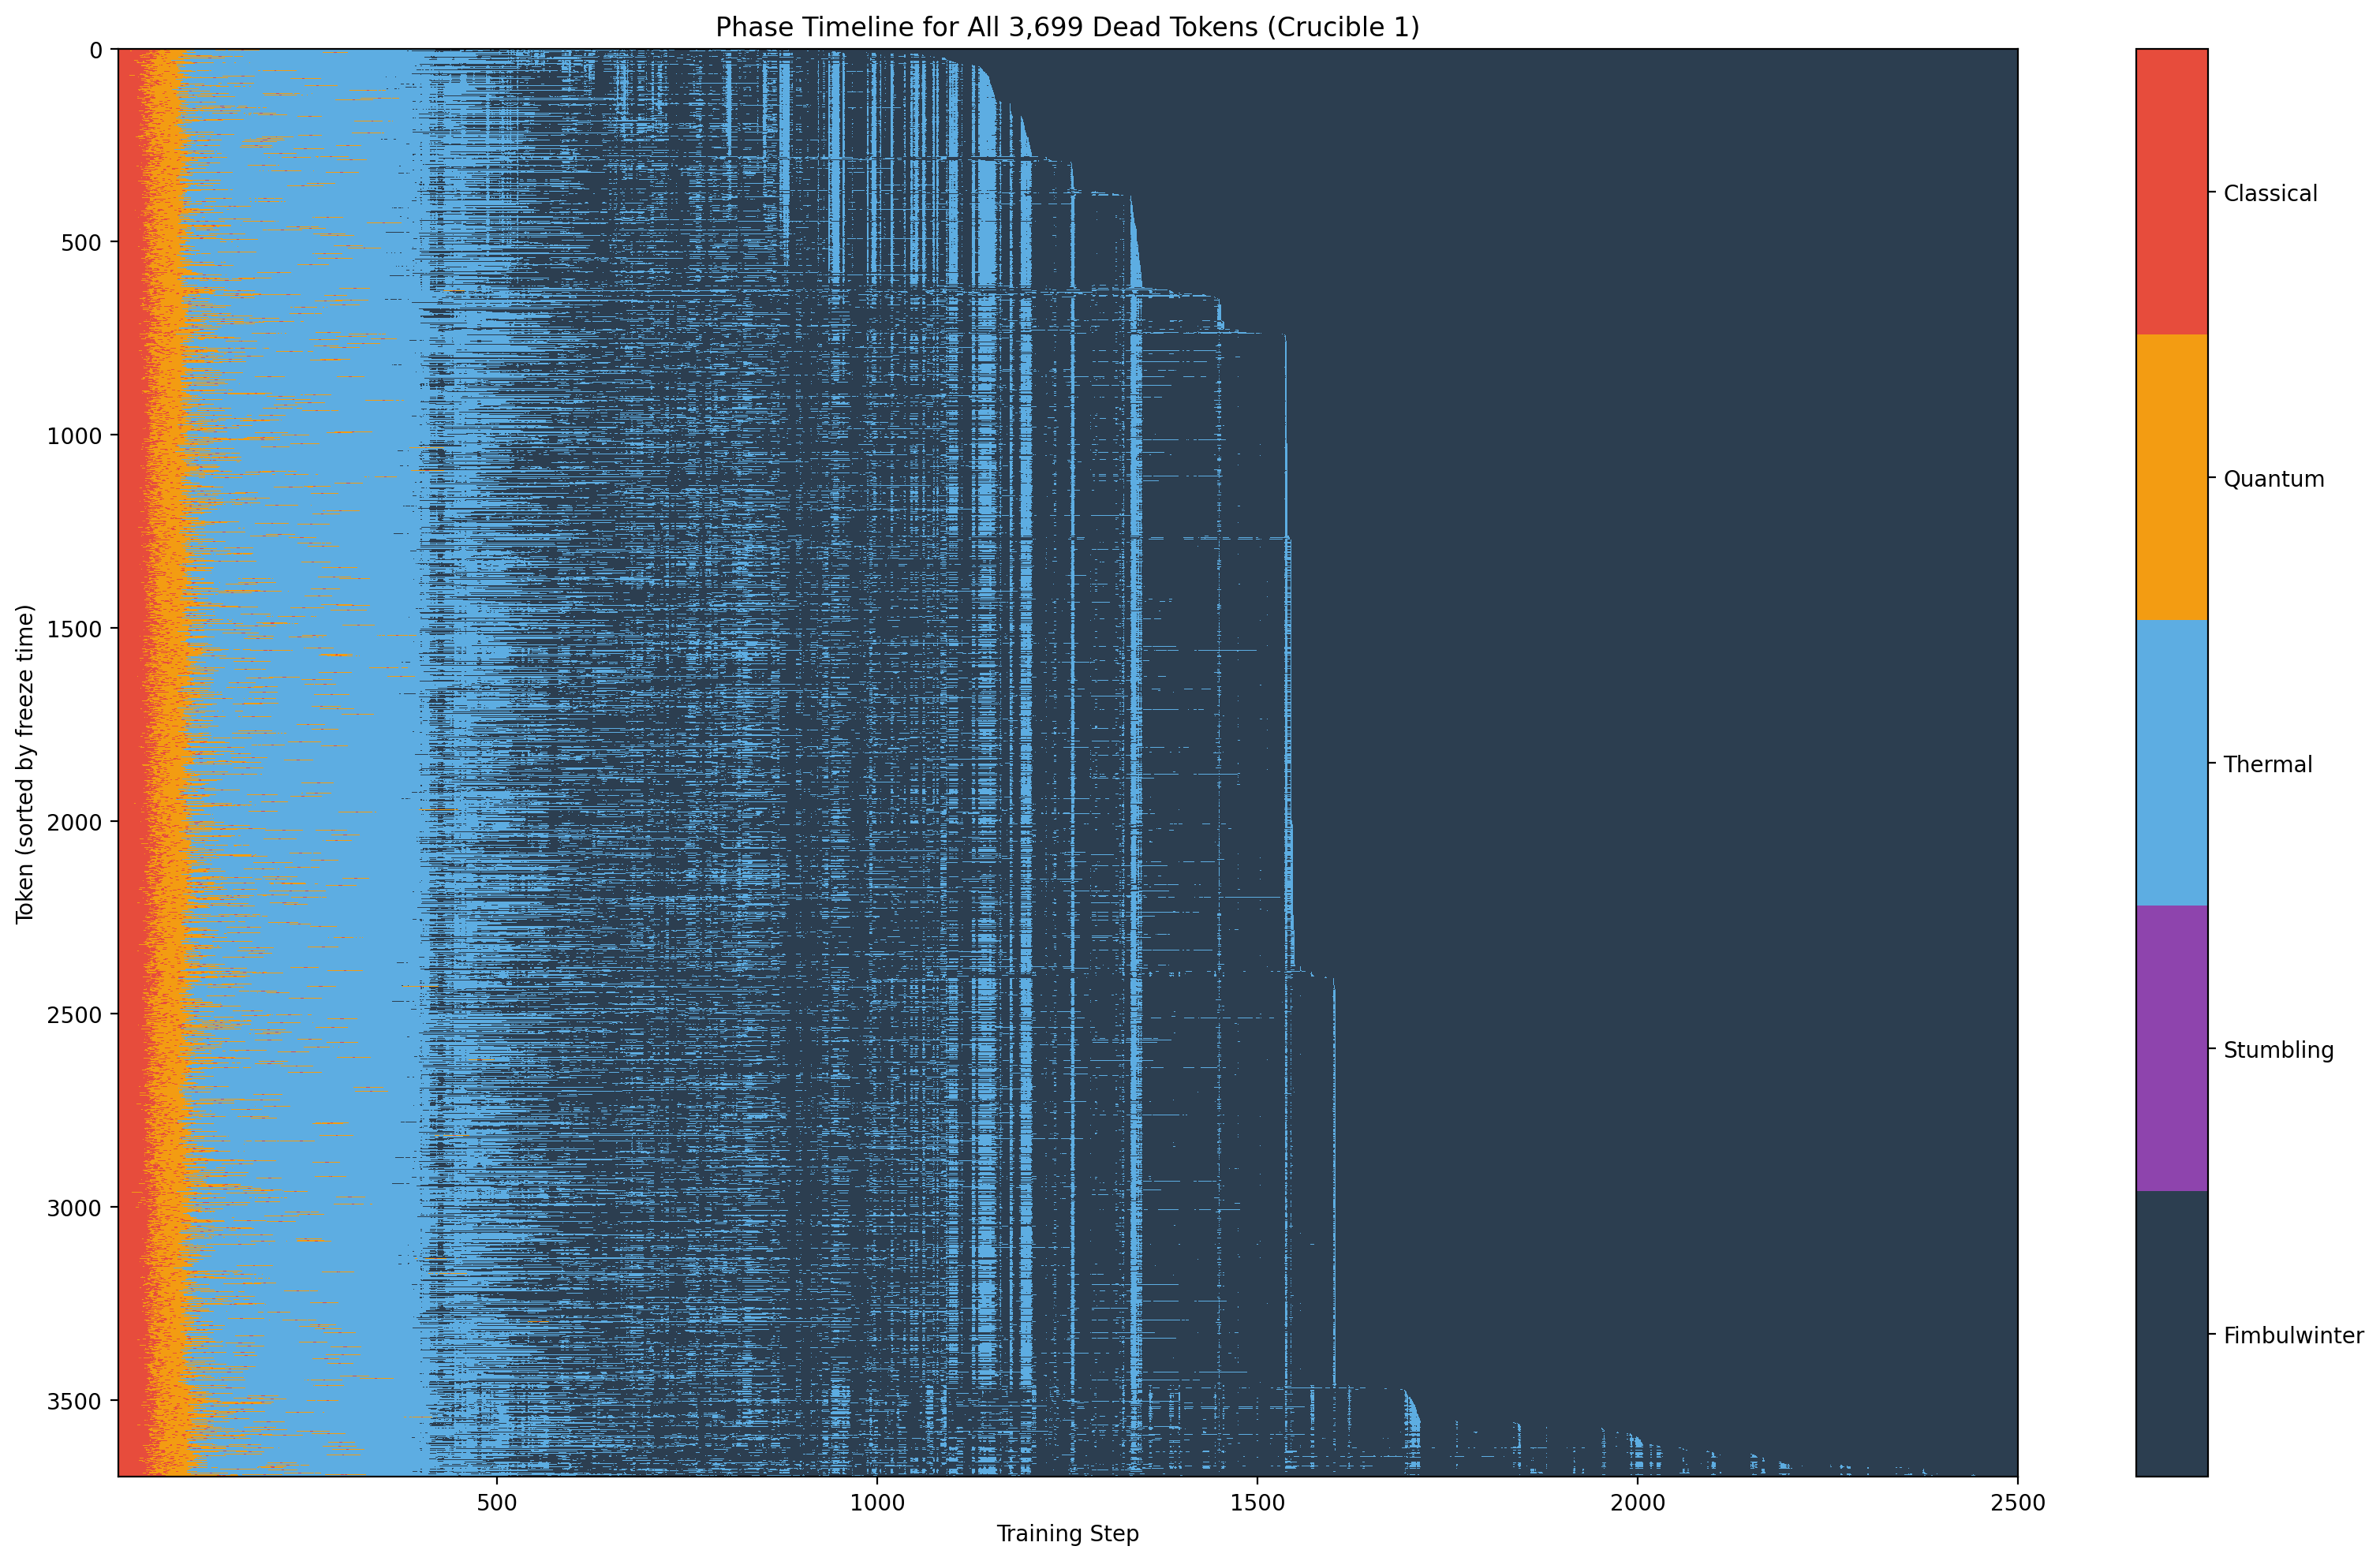

In [28]:
# Full heatmap: ALL 3,699 dead tokens
# This is a big plot but we only have to plot it once (plot plot plot)

fig, ax = plt.subplots(figsize=(16, 10), dpi=200)

# Create a phase map for ALL tokens: 0=fimbulwinter, 1=stumbling, 2=thermal, 3=quantum, 4=classical
disp_np = displacement_magnitude.numpy()
phase_map_full = np.zeros_like(disp_np)
phase_map_full[disp_np >= THRESH_FIMBULWINTER] = 1  # stumbling
phase_map_full[disp_np >= THRESH_STUMBLING] = 2      # thermal
phase_map_full[disp_np >= THRESH_THERMAL] = 3        # quantum
phase_map_full[disp_np >= THRESH_QUANTUM] = 4        # classical

# Plot as heatmap - tokens sorted by their freeze time for visual clarity
freeze_order = np.argsort(t_last_any.numpy())
phase_map_sorted = phase_map_full[:, freeze_order]

from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#2c3e50', '#8e44ad', '#5dade2', '#f39c12', '#e74c3c'])

im = ax.imshow(phase_map_sorted.T, aspect='auto', cmap=cmap, vmin=0, vmax=4,
               extent=[1, n_steps, n_tokens, 0], interpolation='nearest')

ax.set_xlabel('Training Step')
ax.set_ylabel('Token (sorted by freeze time)')
ax.set_title(f'Phase Timeline for All {n_tokens:,} Dead Tokens (Crucible 1)')

ax.set_xlim(1, 2500)

# Colorbar with labels
cbar = plt.colorbar(im, ax=ax, ticks=[0.4, 1.2, 2.0, 2.8, 3.6])
cbar.ax.set_yticklabels(['Fimbulwinter', 'Stumbling', 'Thermal', 'Quantum', 'Classical'])

plt.tight_layout()
plt.show()